In [2]:

import numpy as np             
import math
import regions                                   
import pylab                                
import matplotlib                           
import matplotlib.gridspec as gridspec      
                                           
                                           
import scipy

import astropy.io.fits as fits             
                                           
from astropy.wcs import WCS                 
from astropy import units as u              

import pyspeckit as psk                     
                                            
                                           
from spectral_cube import SpectralCube     

from reproject import reproject_interp     
from reproject.mosaicking import find_optimal_celestial_wcs 


                                            
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

                                            
%matplotlib inline                             

matplotlib.rc('font', family='sans-serif')  
matplotlib.rc('text', usetex=True)      





In [3]:
#this is a list of all of the cube file names and then a list with all the same names but shortened for
#simplicity when working with the spectral cubes
paths=pylab.array(["A.Dust_Ridge_13C16O.cube.I.pbcor.fits","A.Dust_Ridge_12C18O.cube.I.pbcor.fits",
      "A.Dust_Ridge_sci.spw29.cube.I.pbcor.fits","A.Dust_Ridge_sci.spw31.cube.I.pbcor.fits",
     "B.Dust_Ridge_12C16O_1-0.cube.I.pbcor.fits","B.Dust_Ridge_12C17O.cube.I.pbcor.fits",
     "B.Dust_Ridge_sci.spw29.cube.I.pbcor.fits","B.Dust_Ridge_sci.spw31.cube.I.pbcor.fits"])
names_sc=['sc_13C16O', 'sc_12C18O', 'sc_A_sci.spw29', 'sc_A_sci.spw31', 'sc_12C16O', 'sc_12C17O', 'sc_B_sci.spw29', 'sc_B_sci.spw31']

## Gausian Profile for 13C160

In [4]:
path="A.Dust_Ridge_13C16O.cube.I.pbcor.fits"
sc=SpectralCube.read(path)
#reads in the fits file and creaates a spectral cube
sc.allow_huge_operations=True 
#sc_k= sc.to(u.K)
sc_Ghz=sc.with_spectral_unit(u.Hz*10**9)
#changes frequency to GHz
print(sc_Ghz)

SpectralCube with shape=(1917, 288, 288) and unit=Jy / beam:
 n_x:    288  type_x: RA---SIN  unit_x: deg    range:   266.572800 deg:  266.603675 deg
 n_y:    288  type_y: DEC--SIN  unit_y: deg    range:   -28.608259 deg:  -28.581154 deg
 n_s:   1917  type_s: FREQ      unit_s: 1e+09 Hz  range:      110.084 1e+09 Hz:     110.318 1e+09 Hz


Text(0, 0.5, 'Intensity (Jy/Beam)')

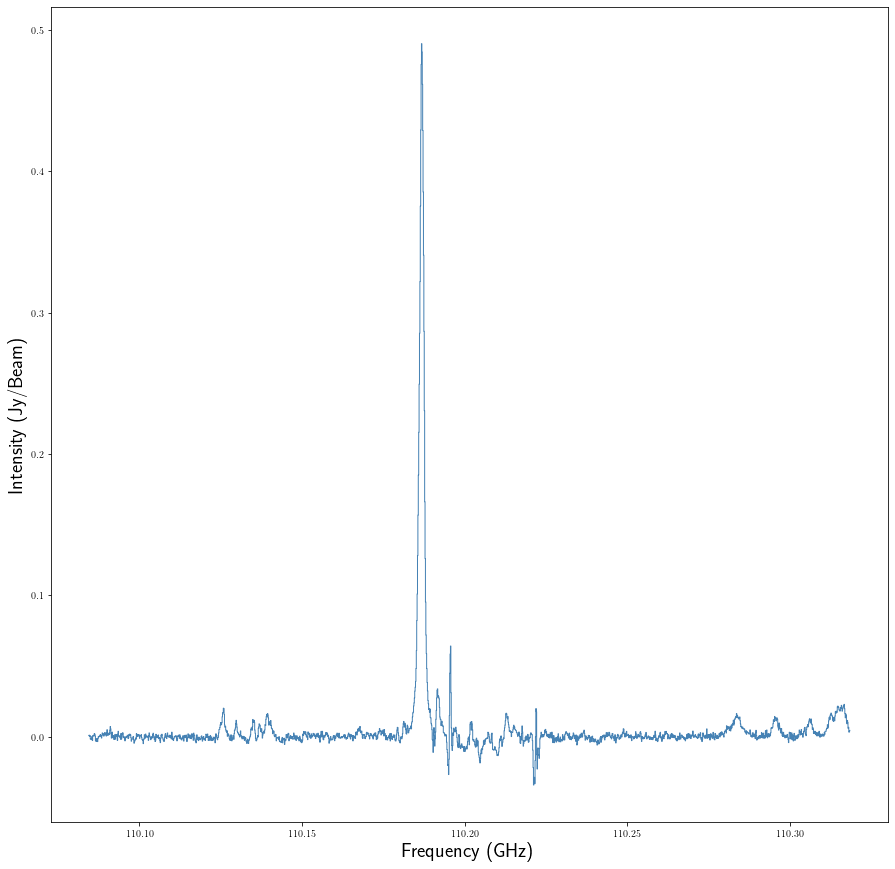

In [5]:
fig1=pylab.figure(1,figsize=(15,15))
#creates our figure that will be plotted on
freq,Dec,Ra = sc_Ghz.world[:,0,0] 
z,x,y=pylab.where(sc_Ghz.hdu.data==np.nanmax(sc_Ghz.hdu.data))
#finds position and freq of the brightest source in the cube
subcube=sc_Ghz.hdu.data[:,int(x)-10:int(x)+10,int(y)-10:int(y)+10]
#creates a 20x20 cubcube around the brightest source
spectrum = np.average(subcube,axis=(1,2)) 
#need to check with prof mills, but I believe this finds the average value
#of each sub cube for each frequency
ax1=pylab.subplot()
ax1.plot(freq,spectrum,lw=1,drawstyle='steps-mid',color="SteelBlue")
pylab.xlabel("Frequency (GHz)", fontsize=20)
pylab.ylabel("Intensity (Jy/Beam)",fontsize=20)
#all of this plots the actual spectrum

## I have moved this code block up to find out why I am getting NaN errors

In [27]:
zoom = np.where((freq.value>110.15)*(freq.value<110.25))
#zooms in on major intensity spike (assumed to be 12CO)
print("Zoom \n",zoom)
zoom_13C160=spectrum[zoom]
print("Zoom_13C160 \n",zoom_13C160)
#zooms in on the spectrum we found in the last code block
zoom_freq = freq[zoom]
print("zoom_freq \n",zoom_freq)
#zooms in on the frequency's in this zoomed in region

#this lot begins to talk about noise. I need to learn more about it and it is
#a WIP, refer back to tutorial
error = np.zeros(np.size(zoom))
print("np.size(zoom) \n",np.size(zoom))
wheremeas = np.where((zoom_freq.value>110.08)*(zoom_freq.value<110.10))
print("wheremeas \n",wheremeas)
meas = np.std(zoom_13C160[wheremeas])  
print("meas \n",meas)
error = error + meas
print("error \n",error)

Zoom 
 (array([ 537,  538,  539,  540,  541,  542,  543,  544,  545,  546,  547,
        548,  549,  550,  551,  552,  553,  554,  555,  556,  557,  558,
        559,  560,  561,  562,  563,  564,  565,  566,  567,  568,  569,
        570,  571,  572,  573,  574,  575,  576,  577,  578,  579,  580,
        581,  582,  583,  584,  585,  586,  587,  588,  589,  590,  591,
        592,  593,  594,  595,  596,  597,  598,  599,  600,  601,  602,
        603,  604,  605,  606,  607,  608,  609,  610,  611,  612,  613,
        614,  615,  616,  617,  618,  619,  620,  621,  622,  623,  624,
        625,  626,  627,  628,  629,  630,  631,  632,  633,  634,  635,
        636,  637,  638,  639,  640,  641,  642,  643,  644,  645,  646,
        647,  648,  649,  650,  651,  652,  653,  654,  655,  656,  657,
        658,  659,  660,  661,  662,  663,  664,  665,  666,  667,  668,
        669,  670,  671,  672,  673,  674,  675,  676,  677,  678,  679,
        680,  681,  682,  683,  684,  685, 

## The actual fitting code

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

ValueError: One or more of the error values is NaN.  This is not allowed.  Errors can be infinite (which is equivalent to giving zero weight to a data point), but otherwise they must be positive floats.

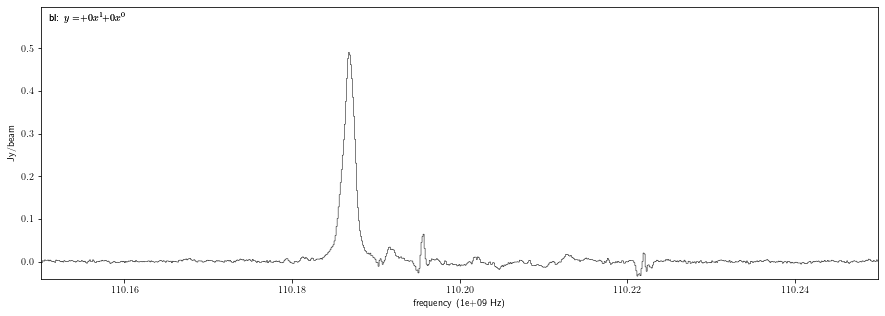

In [17]:
zoom = np.where((freq.value>110.15)*(freq.value<110.25))
#zooms in on major intensity spike (assumed to be 12CO)
zoom_13C160=spectrum[zoom]
#zooms in on the spectrum we found in the last code block
zoom_freq = freq[zoom]
#zooms in on the frequency's in this zoomed in region

#this lot begins to talk about noise. I need to learn more about it and it is
#a WIP, refer back to tutorial
error = np.zeros(np.size(zoom))
wheremeas = np.where((zoom_freq.value>110.08)*(zoom_freq.value<110.10))
meas = np.std(zoom_13C160[wheremeas])  
error = error + meas
print(error)

exclude=pylab.array([110.10,110.30])
#I didn't totally get this value in the tutorial so it will have to be played with

guesses=[0.49,110.1875,.005]
#same for these values, they'll need to be played with
#I changed the final parameter into line width at GHz

limits=[(0.3,0.6),(109.18,111.18),(.003,.009)]
#yet again, needs to be fiddled with
#changed laast parameter to line width

limited=[(True,True),(True,True),(True,True)]

sp = psk.Spectrum(data=zoom_13C160,xarr=zoom_freq,error=error,unit='Jy/beam')

pylab.figure(1,figsize=(15,5))
sp.plotter(axis=pylab.subplot(1,1,1))

sp.baseline(order=1,exclude=exclude)
#mess around with order

sp.specfit(guesses=guesses,limits=limits,limited=limited)

sp.plotter(axis=pylab.subplot(1,1,1),errstyle='fill')

sp.specfit.plot_fit(axis=pylab.subplot(1,1,1),annotate=False)

sp.specfit.plot_components(axis=pylab.subplot(1,1,1),add_baseline=False,component_yoffset=-1)

sp.specfit.plotresiduals(axis=pylab.subplot(1,1,1),clear=False, yoffset=-2,label=False)

sp.plotter.axis.set_ylim(-5,25)
pylab.xlabel("Frequency (GHz)",fontsize=20)
pylab.ylabel("Intensity (Jy/beam)",fontsize=20)
pylab.tick_params(axis='both', which='major',labelsize=15)

print(sp.specfit.parinfo)                   # Print the resulting fitted parameters
Amp_0 = sp.specfit.parinfo[0].value         # You can also access these values and assign them to variables
Amp_err_0 = sp.specfit.parinfo[0].error
dv_0 = sp.specfit.parinfo[2].value
dv_err_0 = sp.specfit.parinfo[2].error
flux_0 = Amp_0 * dv_0 * np.sqrt(2*np.pi)
flux_err_0 = np.sqrt(((Amp_err_0**2+(np.mean(sp.error)/3.0)**2)**0.5/Amp_0)**2+(dv_err_0/dv_0)**2) * flux_0

Amp_1 = sp.specfit.parinfo[3].value
Amp_err_1 = sp.specfit.parinfo[3].error
dv_1 = sp.specfit.parinfo[5].value
dv_err_1 = sp.specfit.parinfo[5].error
flux_1 = Amp_1 * dv_1 * np.sqrt(2*np.pi)
flux_err_1 = np.sqrt(((Amp_err_1**2+(np.mean(sp.error)/3.0)**2)**0.5/Amp_1)**2+(dv_err_1/dv_1)**2) * flux_1

print("")
print("The peak intensities are %1.1f +/- %1.1f K and %1.1f +/- %1.1f K"%(Amp_0,Amp_err_0,Amp_1,Amp_err_1))
print("")
print("The integrated intensities are %1.1f +/- %1.1f K km/s and %1.1f +/- %1.1f K km/s"%(flux_0,flux_err_0,flux_1,flux_err_1))

